<p style="font-family: Arial; font-size:2em; font-style:bold">
<br> Rylie Fleckenstein<br><br> </p>
<p style="font-family: Arial; font-size:1.5em; color:#2462C0; font-style:bold">
June 9, 2021</p>

## Chess: Piece Capture Analysis

## Data background

General Info

This is a set of just over 20,000 games collected from a selection of users on the site Lichess.org. This set contains the:

- Game ID;
- Rated (T/F);
- Start Time;
- End Time;
- Number of Turns;
- Game Status;
- Winner;
- Time Increment;
- White Player ID;
- White Player Rating;
- Black Player ID;
- Black Player Rating;
- All Moves in Standard Chess Notation;
- Opening Eco (Standardised Code for any given opening, list here);
- Opening Name;
- Opening Ply (Number of moves in the opening phase)

link : https://www.kaggle.com/datasnaek/chess

### Research Background

I am planning on continuing the analysis beyond what is done in this document. I have several research ideas in regards to the game of chess and will be updating this document periodically as I accomplish these tasks. The first research question I sought to shed some light on is, "Are there certain squares on the chess board, for each type of piecce, where there is a higher frequency of captures occuring?" That is, are the white pawns making most of their captures on certain squares? Is the black queen making most of its captures on certain squares? The data set I am going to be using has a column called 'moves' which is the complete game annotated in chess notation. I plan to iterate over every game, find where each capture is taking place, determine which piece is making the capture, determine which square the capture is occuring on, and then accumulate this data for each type of chess piece and subsequently plot a heat map of the capture frequencies.

- explain chess notation
- explain each type of piece
- explain why I generalized the pieces 
- explain further research ideas (determining the most frequent piece captured by each type of peice (using back tracking of some sort))


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
chess_dat = pd.read_csv('games.csv')
chess_dat.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [3]:
# convert moves for each game into numpy array so it can be parsed
for i in range(len(chess_dat)):
    chess_dat['moves'][i] = chess_dat['moves'][i].split(" ")

C:\Users\dylle\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Here we can see that each game now has a vector or list of moves

In [14]:
chess_dat['moves'][1]

['d4',
 'Nc6',
 'e4',
 'e5',
 'f4',
 'f6',
 'dxe5',
 'fxe5',
 'fxe5',
 'Nxe5',
 'Qd4',
 'Nc6',
 'Qe5+',
 'Nxe5',
 'c4',
 'Bb4+']

Now is a good time to discuss the notation used for chess and how it can be converted into a coordinate system. In chess, the columns of the board are refered to as files and are annotated with letters ranging from 'a' - 'h'. The rows are refered to as ranks and are annotated with numbers ranging from 1 - 8. Thus, we have an 8x8 board consisting of 64 unique squares. In order to make this notation useful for our computers and in python, we must convert this notation into coordinates. For example, we would want to convert 'd4' into (4,3) and so forth.  

In [5]:
row_conv = {'8':0, '7':1, '6':2,'5':3, '4':4, '3':5, '2':6, '1':7}
col_conv = {'a':0, 'b':1, 'c':2, 'd':3, 'e':4, 'f':5, 'g':6, 'h':7}

In order to complete these conversions in a timely manner we will write a simple function

In [6]:
def notation_to_square(n):
    """
    takes chess notation, returns 2D coordinate
    """
    col = n[0]
    row = n[1]
    return row_conv[row], col_conv[col]

The next portion of the analysis involves iterating over the annotated game moves and finding all of the captures. In chess notation, a capture is signified by an 'x' following the annotation for the piece making the capture and then after the 'x' we are given the square where the capture occured. For example, bishops are denoted by 'B' so if a bishop makes a capture on the square 'd4' the chess notation will read 'Bxd4'. This is also a good time to walk through the different notation for each piece. So, for pawns, these are the most tricky because they are annotated by which file they currently reside. For example, if there is a pawn on the square 'b4' and it captures a piece on the square 'c5' (pawns capture diagonally but thats not important for this part of the analysis), then the notation would read 'bxc5'. Then we have the knights which are denoted by 'N', bishops by 'B', the rooks by 'R', the queen by 'Q', and the king by 'K'. 

In [7]:
# find capture and returns move it occured on and what square that the capture was made
def find_captures(moves):
    captures = {}
    for i in range(len(moves)):
        if 'x' in moves[i]:
            x_index = moves[i].index('x')
            square = moves[i][x_index + 1:]
            piece = moves[i][0]
            captures[i] = square, piece
    return captures

So, if we run this function we can see we given a dictionary object, the key being the move the capture was made on in the game (important for determining which player is making the capture will be explained later), the square on which the capture occured, and then the piece that is making the capture.

In [13]:
find_captures(chess_dat['moves'][1])

{6: ('e5', 'd'),
 7: ('e5', 'f'),
 8: ('e5', 'f'),
 9: ('e5', 'N'),
 13: ('e5', 'N')}

Now, we need to take the piece that is returned to us and determine which piece type it is. This function is mostly written to deal with the pawns since they can be any lower case letter from a-h.

In [9]:
def find_piece_type(piece):
    if set('abcdefgh').intersection(piece):
            piece = 'p'
    else:
        piece = str(piece)
    return piece

Alright, now that we have these starter function, we are ready to initialize a dictionary that is going to save all of the captures that occur in the entire dataset by piece type. I have one key for each type, 'w_p' for the white pawns, 'w_R' for the white rooks, 'w_N' for the white nights, 'w_B' for the white bishops, 'w_Q' for the white queen, 'w_K' for the white king, and then the same for the black pieces but instead of a w they all start with a b.

In [10]:
captures_dict = {'w_p': [], 'w_R': [], 'w_N': [], 'w_B': [], 'w_Q': [], 'w_K': [],
                'b_p': [], 'b_R': [], 'b_N': [], 'b_B': [], 'b_Q': [], 'b_K': []}

Alright, so the last thing we need to do is determine which player (or color of pieces) is making the capture. This is where the move on which the capture occured finally comes into play. In the game of chess, the player with the white pieces always makes the first move and since python indexing starts with 0, each move made by white will be an even number (0, 2, 4, 6, 8). The code below finds the captures, determines which square it took place on, determines which piece and white color made the capture, and then appends the coordinate as a tuple into the captures_dictionary.

In [11]:
caps = find_captures(chess_dat['moves'][1])
for capture in caps:
    
    notation = caps[capture][0]
    piece = caps[capture][1]
    square = notation_to_square(notation)
    
    if capture % 2 == 0:
        piece = 'w_' + find_piece_type(piece)
    else:
        piece = 'b_' + find_piece_type(piece)
        
    captures_dict[piece].append(square)
    print(piece + ' ' + 'captured on square' + ' ' + notation)

w_p captured on square e5
b_p captured on square e5
w_p captured on square e5
b_N captured on square e5
b_N captured on square e5


We can see our code is working properly so we are going to reinitialize or reset the captures_dict and write a quick function so that we can deploy this code accross the entire dataset instead of just on one game.

In [15]:
captures_dict

{'w_p': [(3, 4), (3, 4)],
 'w_R': [],
 'w_N': [],
 'w_B': [],
 'w_Q': [],
 'w_K': [],
 'b_p': [(3, 4)],
 'b_R': [],
 'b_N': [(3, 4), (3, 4)],
 'b_B': [],
 'b_Q': [],
 'b_K': []}

In [16]:
captures_dict = {'w_p': [], 'w_R': [], 'w_N': [], 'w_B': [], 'w_Q': [], 'w_K': [],
                'b_p': [], 'b_R': [], 'b_N': [], 'b_B': [], 'b_Q': [], 'b_K': []}

In [17]:
def pieces_captures_by_square(game):
    
    caps = find_captures(chess_dat['moves'][game])
    for capture in caps:

        notation = caps[capture][0]
        piece = caps[capture][1]
        square = notation_to_square(notation)

        if capture % 2 == 0:
            piece = 'w_' + find_piece_type(piece)
        else:
            piece = 'b_' + find_piece_type(piece)

        captures_dict[piece].append(square)


Here we deploy our function accross the entire dataset. Note, we took the time to write small functions for each specific task before consolidating it into one main function which allows our final deployment code to be relatively simple.

In [18]:
for i in range(len(chess_dat)):
    pieces_captures_by_square(i)

Now that we have deployed our function to every game in the dataset, we have a dictionary 'captures_dict' that contains a list of tuples (coordinates of each capture) for each type of piece. What we need to do, is generate dictionaries for each type of piece where the keys are the coordinates and the values are the number of times those values occured for each piece in the 'captures_dict'. So, we create a counter function and we can see that the occurences for 'w_p' is now a dictionary of coordinates and the number of times captures occured on the coordinates by the piece type 'w_p'.

In [19]:
def counter(it):
    counts = {}
    for item in it:
        try:
            counts[item] += 1
        except KeyError:
            counts[item] = 1
    return counts

In [20]:
occurences = counter(captures_dict['w_p'])

In [26]:
occurences

{(1, 6): 577,
 (0, 3): 488,
 (4, 7): 111,
 (3, 5): 157,
 (1, 5): 822,
 (2, 5): 248,
 (0, 5): 354,
 (2, 7): 106,
 (1, 3): 392,
 (0, 4): 152,
 (4, 5): 129,
 (0, 7): 63,
 (1, 4): 328,
 (6, 7): 46,
 (5, 6): 70,
 (1, 7): 225,
 (4, 6): 130,
 (3, 7): 107,
 (4, 4): 97,
 (0, 0): 28,
 (3, 1): 87,
 (6, 0): 73,
 (4, 0): 81,
 (5, 7): 86,
 (2, 3): 181,
 (3, 4): 182,
 (5, 4): 46,
 (0, 6): 86,
 (3, 6): 173,
 (5, 1): 52,
 (6, 5): 42,
 (6, 2): 24,
 (3, 0): 70,
 (1, 1): 100,
 (2, 4): 224,
 (2, 2): 130,
 (4, 1): 86,
 (6, 1): 56,
 (5, 0): 80,
 (2, 6): 152,
 (5, 2): 78,
 (1, 2): 127,
 (7, 0): 12,
 (4, 3): 89,
 (1, 0): 54,
 (7, 5): 8,
 (7, 6): 8,
 (2, 0): 46,
 (3, 2): 104,
 (7, 1): 11,
 (5, 5): 69,
 (4, 2): 104,
 (0, 1): 20,
 (3, 3): 127,
 (7, 4): 8,
 (6, 3): 16,
 (6, 6): 38,
 (0, 2): 66,
 (2, 1): 51,
 (5, 3): 23,
 (7, 3): 9,
 (7, 2): 16,
 (7, 7): 11,
 (6, 4): 9}

Now, in order to vizualise this data I decided I wanted to use heatmaps. The trick with that is, all of our data is stored in a dictionary but the best way to generate a heatmap of an 8x8 board is through the use of a 2D numpy array. So, I initialized a 2D numpy array of zeros with dimension 8x8 and then wrote a nested for loop to set the value for each square in the 2D numpy array based upon the stored values in our occurences dictionary. If there is a value saved in the dictionary for the sqaure the loop is iterating over, the value will be appended to the array and if there is no value in the dictionary for that square a 0 will be appended.

In [21]:
cap_counts = np.zeros((8,8))

In [22]:
for i in range(8):
    for j in range(8):
        try:
            cap_counts[i][j] = occurences[(i, j)]
        except:
            cap_counts[i][j] = 0

In [23]:
cap_counts

array([[  21.,   13.,   17.,   24.,   17.,   26.,    8.,    8.],
       [  14.,   94.,   99.,   73.,   85.,  149.,  135.,   43.],
       [ 145.,  352.,  913.,  820.,  660., 1071.,  564.,  141.],
       [ 309., 1111., 1879., 6168., 3671., 1295.,  914.,  259.],
       [ 166., 1144.,  867., 2390., 1385.,  715., 1151.,  198.],
       [ 187.,  683., 2046.,  448.,  833., 1248.,  874.,  320.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]])

Now we can plot a heatmap of the captures

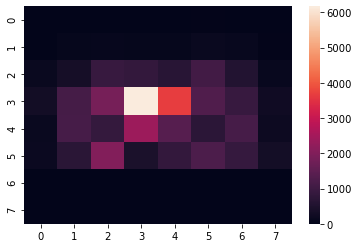

In [24]:
ax = sns.heatmap(cap_counts)
plt.show()

Now, to deploy this functionality across all of the different piece type I just wrote a simple for loop and below we can see the amazing results.

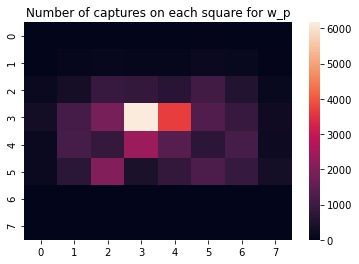

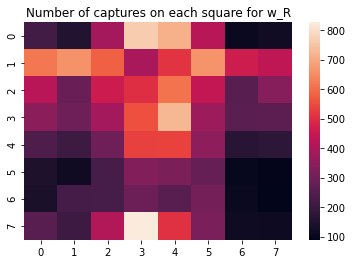

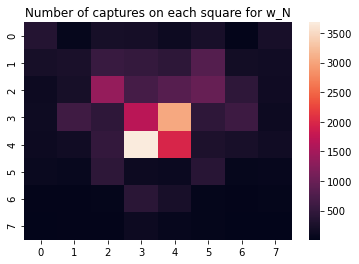

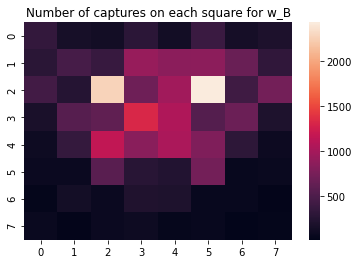

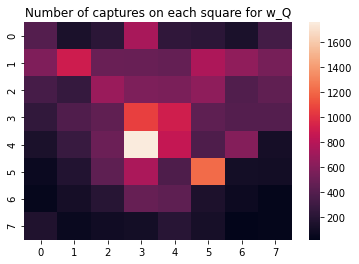

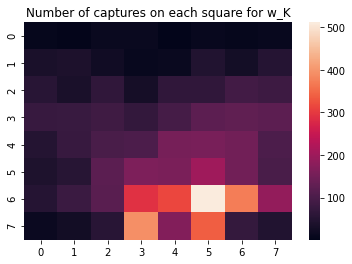

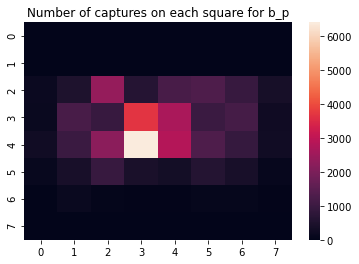

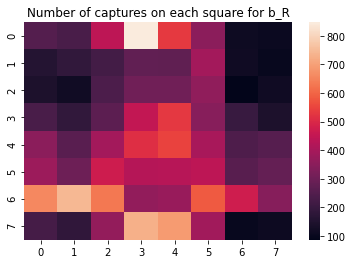

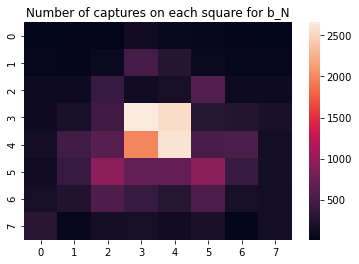

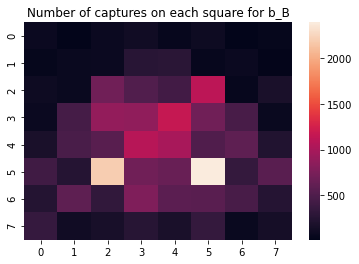

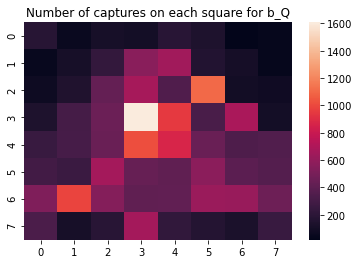

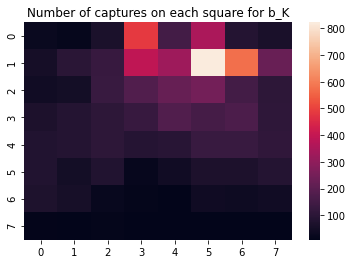

In [25]:
for key in captures_dict.keys():
    occurences = counter(captures_dict[key])
    cap_counts = np.zeros((8,8))
    
    for i in range(8):
        for j in range(8):
            try:
                cap_counts[i][j] = occurences[(i, j)]
            except:
                cap_counts[i][j] = 0
            
    ax = sns.heatmap(cap_counts)
    plt.title('Number of captures on each square for' + ' ' + key)
    plt.show()

### Thoughts

At the moment I have not taken much time to give these results meaning in the context of the game but plan on doing so in the near future. But, for now and at a quick first glance, I do think it is pretty cool to see how certain pieces do have hot spots where most of the captures they commit are taking place and I do believe there is much to be learned from this data. 